In [32]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from random import sample
import seaborn as sns
import pandas as pd

In [2]:
base_path = 'C:/Users/w11/Documents/archive'

image_paths = glob(os.path.join(base_path, '**', '*.png'), recursive=True)

print(f'{len(image_paths)} imagens encontradas.')
print('Primeiros arquivos:')
for path in image_paths[:5]:
    print(path)

555048 imagens encontradas.
Primeiros arquivos:
C:/Users/w11/Documents/archive\10253\0\10253_idx5_x1001_y1001_class0.png
C:/Users/w11/Documents/archive\10253\0\10253_idx5_x1001_y1051_class0.png
C:/Users/w11/Documents/archive\10253\0\10253_idx5_x1001_y1101_class0.png
C:/Users/w11/Documents/archive\10253\0\10253_idx5_x1001_y1151_class0.png
C:/Users/w11/Documents/archive\10253\0\10253_idx5_x1001_y1201_class0.png


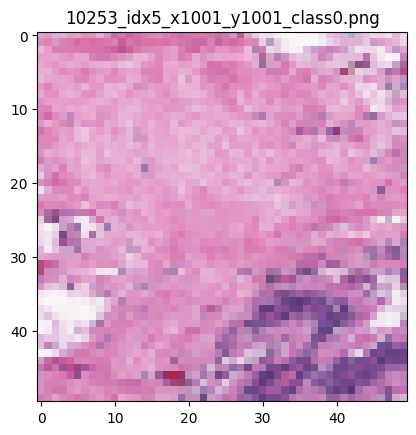

In [3]:
def plot_image(image_path):
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(image_path))
    plt.show()

plot_image(image_paths[0])


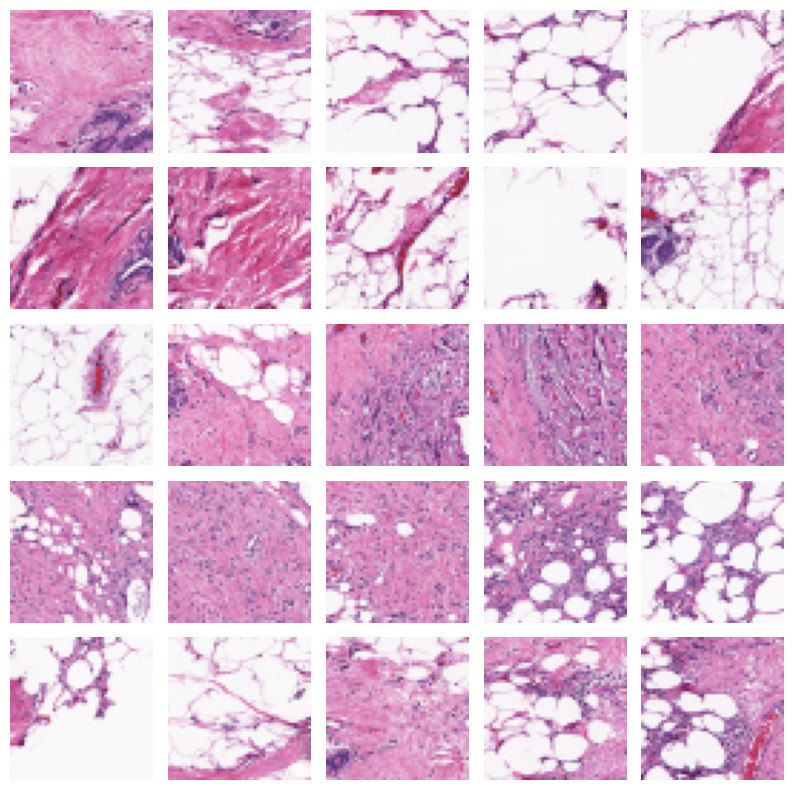

In [4]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i_, path in enumerate(image_paths[:25]):
    img = cv2.imread(path)
    img = cv2.resize(img, (50, 50))

    plt.subplot(5, 5, i_ + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()

In [5]:
sample_size = 300000
sample_paths = sample(image_paths, sample_size)

X = []
y = []

# Carregando as imagens
for path in tqdm(sample_paths, desc=f"Carregando {sample_size} imagens"):
    img = cv2.imread(path)
    if img is None:
        continue
    img = cv2.resize(img, (50, 50))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X.append(img)

    # Rótulo baseado na pasta (0 ou 1)
    label = 1 if os.path.sep + '1' + os.path.sep in path else 0
    y.append(label)

# Conversão para arrays numpy
X = np.array(X, dtype='float32') / 255.0  # normalizado
y = np.array(y)

print(f'\nTotal de imagens carregadas: {len(X)}')
print(f'Formato X: {X.shape}, Formato y: {y.shape}')
print(f'Rótulos: {np.unique(y, return_counts=True)}')

Carregando 300000 imagens: 100%|██████████| 300000/300000 [14:18<00:00, 349.41it/s]



Total de imagens carregadas: 300000
Formato X: (300000, 50, 50, 3), Formato y: (300000,)
Rótulos: (array([0, 1]), array([214696,  85304]))


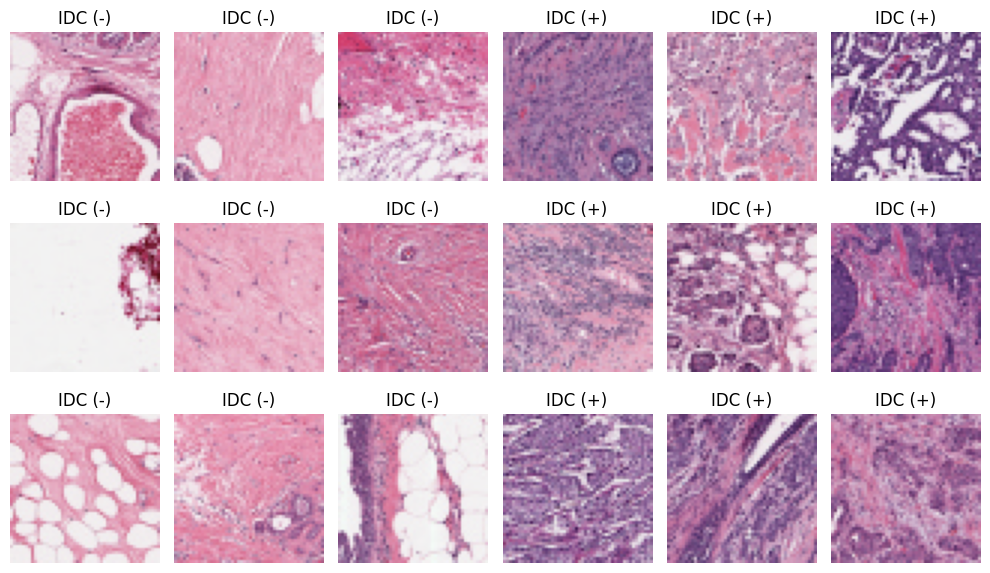

In [6]:
def plotTwoBlocks(X, y):
    # Seleciona índices das imagens para cada classe
    idx_0 = np.where(y == 0)[0][:9]
    idx_1 = np.where(y == 1)[0][:9]
    
    # Garante que tem imagens suficientes em ambos os grupos
    total_to_plot = min(len(idx_0), len(idx_1), 9)
    
    plt.figure(figsize=(10, 6))  # largura * 2 blocos
    
    for i in range(total_to_plot):
        row = i // 3
        col = i % 3
        
        # Posição no grid para IDC (-) - bloco esquerdo
        plt.subplot(3, 6, row * 6 + col + 1)
        plt.imshow(X[idx_0[i]])
        plt.title('IDC (-)')
        plt.axis('off')
        
        # Posição no grid para IDC (+) - bloco direito
        plt.subplot(3, 6, row * 6 + col + 1 + 3)
        plt.imshow(X[idx_1[i]])
        plt.title('IDC (+)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plotTwoBlocks(X, y)

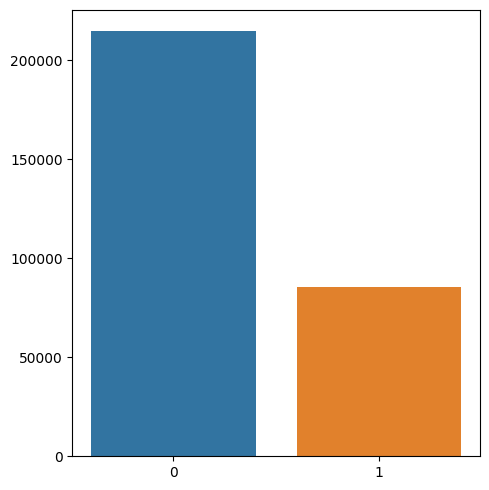

In [7]:
def plot_sample_distribution(y):
    labels, counts = np.unique(y, return_counts=True)

    plt.figure(figsize=(5, 5))
    plt.bar(labels, counts, color=['#3274A1', '#E1812C'])
    plt.xticks(labels, [f'{int(label)}' for label in labels])
    plt.tight_layout()
    plt.show()

plot_sample_distribution(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f'Tamanho treino: {X_train.shape}, Teste: {X_test.shape}')
print(f'Classes no treino: {np.unique(y_train, return_counts=True)}')
print(f'Classes no teste: {np.unique(y_test, return_counts=True)}')

Tamanho treino: (240000, 50, 50, 3), Teste: (60000, 50, 50, 3)
Classes no treino: (array([0, 1]), array([171757,  68243]))
Classes no teste: (array([0, 1]), array([42939, 17061]))


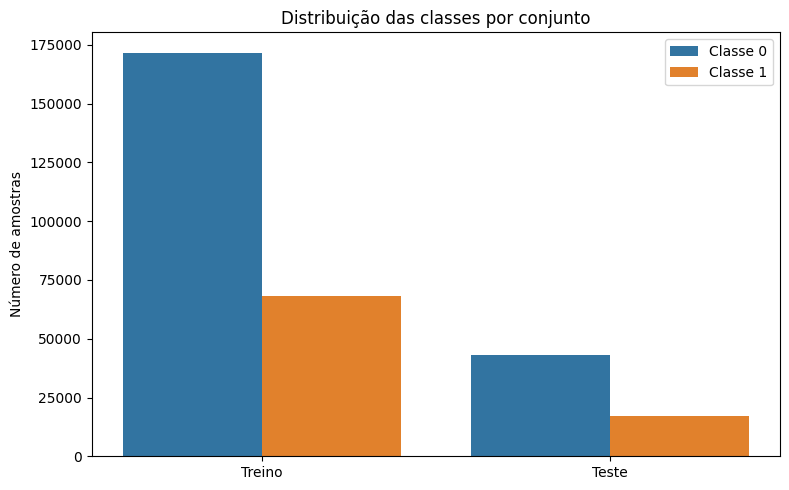

In [9]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

x = ['Treino', 'Teste']
classe_0 = [train_counts[0], test_counts[0]]
classe_1 = [train_counts[1], test_counts[1]]

fig, ax = plt.subplots(figsize=(8, 5))
width = 0.4

ax.bar(np.arange(len(x)) - width/2, classe_0, width, label='Classe 0', color='#3274A1')
ax.bar(np.arange(len(x)) + width/2, classe_1, width, label='Classe 1', color='#E1812C')

ax.set_ylabel('Número de amostras')
ax.set_title('Distribuição das classes por conjunto')
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.legend()

plt.tight_layout()
plt.show()

Criando um modelo de CNN LeNet

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_lenet_regularized(input_shape):
    model = Sequential([
        Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(16, kernel_size=(5, 5), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(120, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        
        Dense(84, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lenet = create_lenet_regularized((50, 50, 3))
lenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │       192,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,241 (801.72 KB)

 Trainable params: 205,241 (801.72 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

history = lenet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8054 - loss: 0.4949 - val_accuracy: 0.8249 - val_loss: 0.4109
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8337 - loss: 0.4132 - val_accuracy: 0.8275 - val_loss: 0.4197
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8371 - loss: 0.4065 - val_accuracy: 0.8448 - val_loss: 0.3835
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8400 - loss: 0.4002 - val_accuracy: 0.8431 - val_loss: 0.3881
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8427 - loss: 0.3952 - val_accuracy: 0.8458 - val_loss: 0.3866
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8442 - loss: 0.3913 - val_accuracy: 0.8467 - val_loss: 0.3745
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8484 - loss: 0.3852 - val_accuracy: 0.8497 - val_loss: 0.3767
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8466 - loss: 0

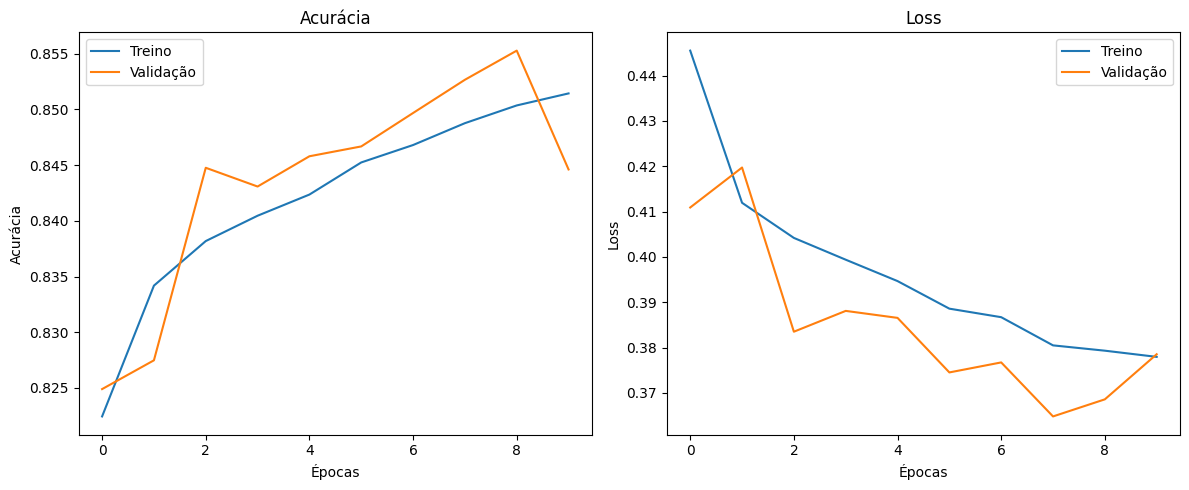

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
test_loss, test_acc = lenet.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")
print(f"Loss no conjunto de teste: {test_loss:.4f}")

Acurácia no conjunto de teste: 0.8527
Loss no conjunto de teste: 0.3648


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9013    0.8918    0.8965     42939
           1     0.7347    0.7542    0.7443     17061

    accuracy                         0.8527     60000
   macro avg     0.8180    0.8230    0.8204     60000
weighted avg     0.8539    0.8527    0.8532     60000



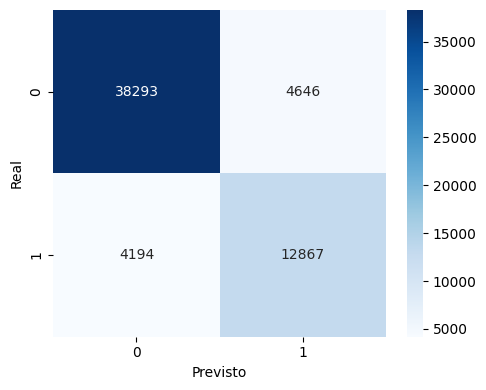

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (lenet.predict(X_test) > 0.5).astype("int32").flatten()

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

Criando um modelo de CNN VGG Customizado

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_vgg_like(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg_model = create_vgg_like((50, 50, 3))
vgg_model.summary()

c:\Users\w11\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,647,329 (10.10 MB)

 Trainable params: 2,647,329 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg = vgg_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 124s 33ms/step - accuracy: 0.8207 - loss: 0.4475 - val_accuracy: 0.8605 - val_loss: 0.3502
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 33ms/step - accuracy: 0.8612 - loss: 0.3372 - val_accuracy: 0.8666 - val_loss: 0.3229
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 33ms/step - accuracy: 0.8696 - loss: 0.3191 - val_accuracy: 0.8674 - val_loss: 0.3238
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 124s 33ms/step - accuracy: 0.8731 - loss: 0.3143 - val_accuracy: 0.8784 - val_loss: 0.2970
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 124s 33ms/step - accuracy: 0.8795 - loss: 0.3010 - val_accuracy: 0.8784 - val_loss: 0.2977
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 124s 33ms/step - accuracy: 0.8804 - loss: 0.2967 - val_accuracy: 0.8849 - val_loss: 0.2851
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 124s 33ms/step - accuracy: 0.8828 - loss: 0.2913 - val_accuracy: 0.8836 - val_loss: 0.2887
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 125s 33ms/step - accuracy: 

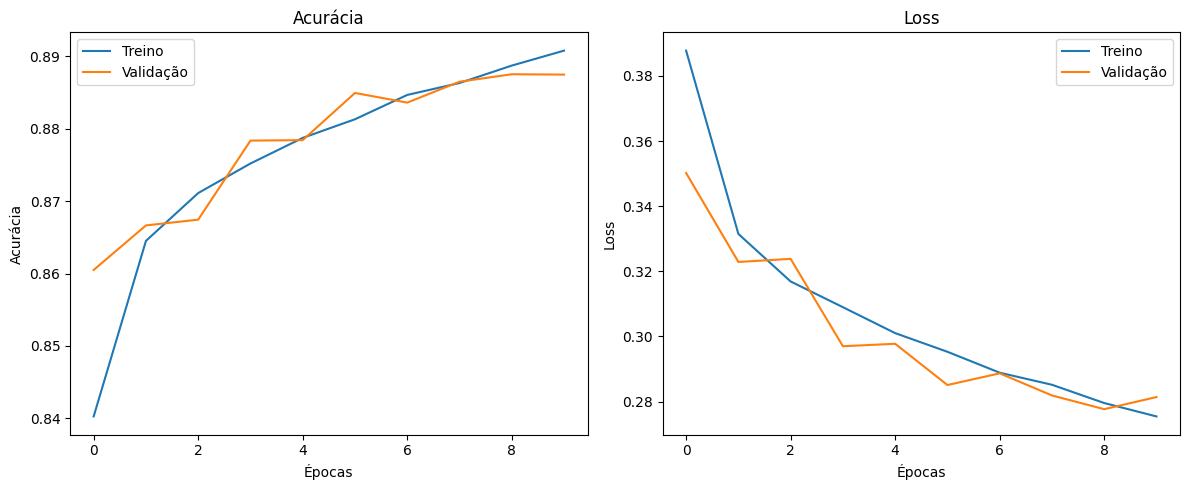

In [23]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_vgg)

In [24]:
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia no conjunto de teste (VGG): {test_acc_vgg:.4f}")
print(f"Loss no conjunto de teste (VGG): {test_loss_vgg:.4f}")

Acurácia no conjunto de teste (VGG): 0.8875
Loss no conjunto de teste (VGG): 0.2777


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Relatório de Classificação - VGG:
              precision    recall  f1-score   support

           0     0.9119    0.9330    0.9223     42939
           1     0.8209    0.7732    0.7963     17061

    accuracy                         0.8875     60000
   macro avg     0.8664    0.8531    0.8593     60000
weighted avg     0.8860    0.8875    0.8865     60000



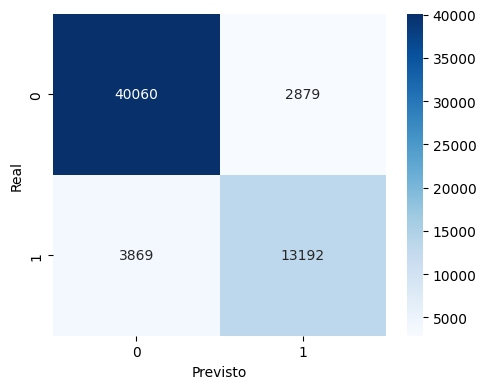

In [28]:
y_pred_vgg = (vgg_model.predict(X_test) > 0.5).astype("int32").flatten()

print("Relatório de Classificação - VGG:")
print(classification_report(y_test, y_pred_vgg, digits=4))

cm_vgg = confusion_matrix(y_test, y_pred_vgg)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_vgg, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


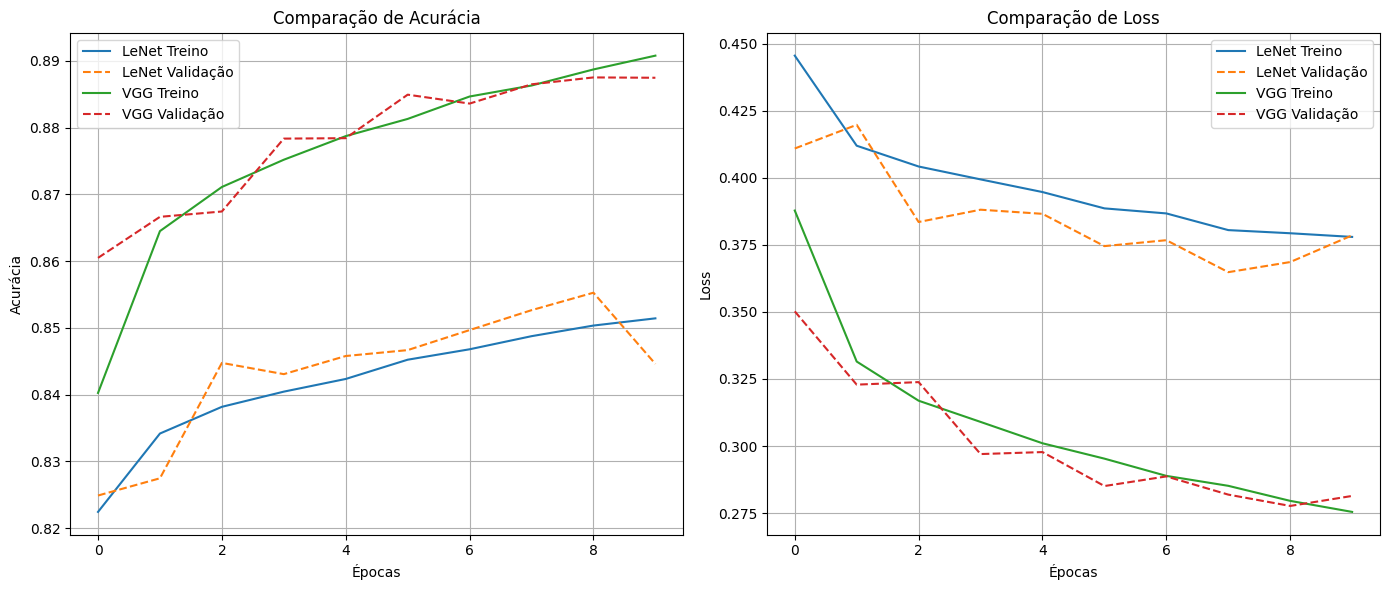

In [26]:
def plot_comparison(histories, labels):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} Treino')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{label} Validação')
    plt.title('Comparação de Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Treino')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{label} Validação')
    plt.title('Comparação de Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_comparison([history, history_vgg], ['LeNet', 'VGG'])